# Análise do Desmatamento na Amazônia usando Modelos Probabilísticos

Este notebook apresenta uma análise abrangente do desmatamento na Amazônia entre 2004-2019 utilizando dois modelos probabilísticos complementares:

1. **Modelos Ocultos de Markov (HMM)** - Para identificar regimes temporais e fazer previsões
2. **Redes Bayesianas Dinâmicas (DBN)** - Para modelar relações causais entre variáveis

## Estrutura do Notebook

O notebook está organizado da seguinte forma:

1. **Carregamento e Preparação dos Dados** - Dados de desmatamento, El Niño/La Niña e queimadas
2. **Análise Exploratória** - Visualização e correlação entre as variáveis
3. **Modelagem com HMM** - Identificação de regimes ocultos de desmatamento
4. **Simulações com HMM** - Projeções futuras de desmatamento até 2050
5. **Modelagem com Rede Bayesiana** - Representação da estrutura causal
6. **Inferência Probabilística** - Consultas condicionais na rede bayesiana
7. **Comparação dos Modelos** - Análise comparativa das abordagens

Cada seção contém explicações detalhadas e visualizações para facilitar a compreensão.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from pgmpy.models import DynamicBayesianNetwork, DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.estimators import BayesianEstimator
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# ---------- 1. Dados de Desmatamento ---------- 
desmatamento = pd.read_csv('../data/def_area_2004_2019.csv.xls')
desmatamento.rename(columns={'Ano/Estados': 'Ano'}, inplace=True)

# ---------- 2. Dados de El Niño/La Niña ----------
elnino = pd.read_csv('../data/el_nino_la_nina_1999_2019.csv.xls')
anos = range(2004, 2020)
dados_anuais = pd.DataFrame({'year': anos})

def obter_fenomeno(ano):
    for _, row in elnino.iterrows():
        if row['start year'] <= ano <= row['end year']:
            return row['phenomenon']
    return 'Neutral'

def obter_severidade(ano):
    for _, row in elnino.iterrows():
        if row['start year'] <= ano <= row['end year']:
            return row['severity']
    return 'None'

dados_anuais['Status'] = dados_anuais['year'].apply(obter_fenomeno)
dados_anuais['Severity'] = dados_anuais['year'].apply(obter_severidade)
elnino_filtrado = dados_anuais[dados_anuais['year'].between(2004, 2019)]
mapeamento = {'La Nina': -1, 'Neutral': 0, 'El Nino': 1}
elnino_filtrado['Status_Numerico'] = elnino_filtrado['Status'].map(mapeamento)

# ---------- 3. Dados Queimadas ----------
queimadas = pd.read_csv('../data/inpe_brazilian_amazon_fires_1999_2019.csv.xls')
queimadas_filtrado = queimadas[queimadas['year'].between(2004, 2019)]
queimadas_anual = queimadas_filtrado.groupby('year')['firespots'].sum().reset_index()
queimadas_anual.rename(columns={'year': 'Year', 'firespots': 'Numero_Queimadas'}, inplace=True)

# ---------- 4. Combinação dos Dados ----------
anos = list(range(2004, 2020))
dados_combinados = pd.DataFrame({'Ano': anos})
dados_combinados = dados_combinados.merge(
    desmatamento[['Ano', 'AMZ LEGAL']], 
    on='Ano', 
    how='left'
)
dados_combinados.rename(columns={'AMZ LEGAL': 'Desmatamento_Total'}, inplace=True)
dados_combinados = dados_combinados.merge(
    elnino_filtrado[['year', 'Status', 'Status_Numerico']], 
    left_on='Ano', 
    right_on='year', 
    how='left'
)
dados_combinados.drop('year', axis=1, inplace=True)
dados_combinados = dados_combinados.merge(
    queimadas_anual[['Year', 'Numero_Queimadas']], 
    left_on='Ano', 
    right_on='Year', 
    how='left'
)
dados_combinados.drop('Year', axis=1, inplace=True)

# ---------- 5. Preparação dos dados para os modelos ----------
# Normalização para o modelo HMM
dados_norm = dados_combinados.copy()
dados_norm['Desmatamento_Norm'] = (dados_combinados['Desmatamento_Total'] - dados_combinados['Desmatamento_Total'].min()) / (dados_combinados['Desmatamento_Total'].max() - dados_combinados['Desmatamento_Total'].min())
dados_norm['Queimadas_Norm'] = (dados_combinados['Numero_Queimadas'] - dados_combinados['Numero_Queimadas'].min()) / (dados_combinados['Numero_Queimadas'].max() - dados_combinados['Numero_Queimadas'].min())

# Discretização para a Rede Bayesiana
dados_cat = dados_combinados.copy()
bins_desmatamento = [0, 6000, 10000, float('inf')]
labels_desmatamento = ['Baixo', 'Medio', 'Alto']
dados_cat['Desmatamento_Cat'] = pd.cut(dados_cat['Desmatamento_Total'], 
                                      bins=bins_desmatamento, 
                                      labels=labels_desmatamento)
bins_queimadas = [0, 150000, 200000, float('inf')]
labels_queimadas = ['Baixo', 'Medio', 'Alto']
dados_cat['Queimadas_Cat'] = pd.cut(dados_cat['Numero_Queimadas'], 
                                   bins=bins_queimadas, 
                                   labels=labels_queimadas)

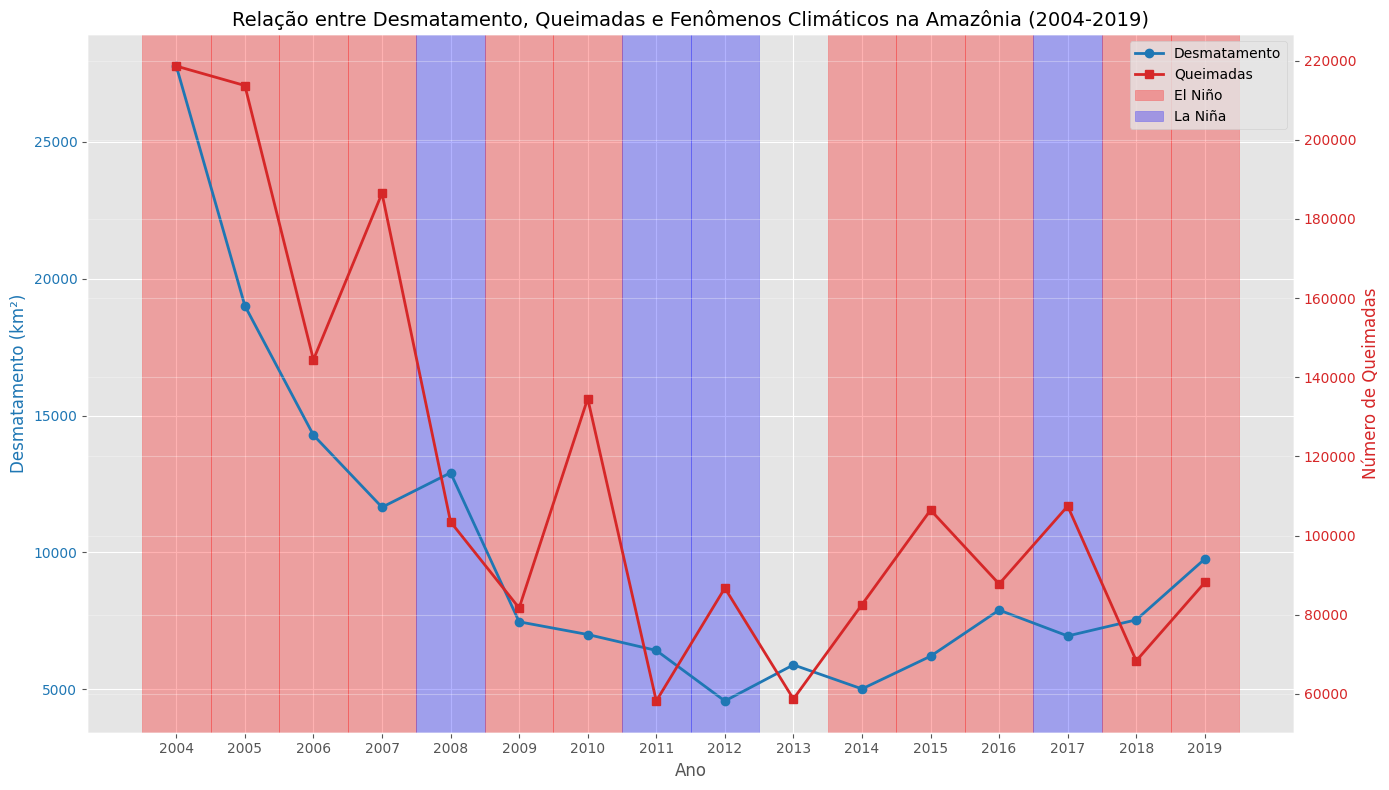

Correlação entre variáveis:
                    Desmatamento_Total  Status_Numerico  Numero_Queimadas
Desmatamento_Total            1.000000         0.276348          0.833778
Status_Numerico               0.276348         1.000000          0.372254
Numero_Queimadas              0.833778         0.372254          1.000000


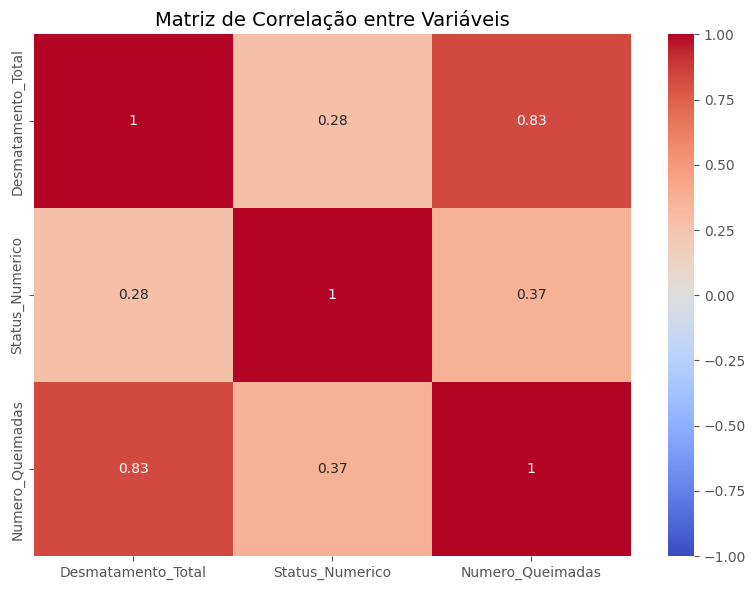

In [3]:
fig, ax1 = plt.subplots(figsize=(14, 8))

color = 'tab:blue'
ax1.set_xlabel('Ano', fontsize=12)
ax1.set_ylabel('Desmatamento (km²)', color=color, fontsize=12)
ax1.plot(dados_combinados['Ano'], dados_combinados['Desmatamento_Total'], 
         color=color, marker='o', linewidth=2, label='Desmatamento')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Número de Queimadas', color=color, fontsize=12)
ax2.plot(dados_combinados['Ano'], dados_combinados['Numero_Queimadas'], 
         color=color, marker='s', linewidth=2, label='Queimadas')
ax2.tick_params(axis='y', labelcolor=color)

for i, row in dados_combinados.iterrows():
    if row['Status'] == 'El Nino':
        ax1.axvspan(row['Ano'] - 0.5, row['Ano'] + 0.5, alpha=0.3, color='red')
    elif row['Status'] == 'La Nina':
        ax1.axvspan(row['Ano'] - 0.5, row['Ano'] + 0.5, alpha=0.3, color='blue')

import matplotlib.patches as mpatches
elniño = mpatches.Patch(color='red', alpha=0.3, label='El Niño')
laniña = mpatches.Patch(color='blue', alpha=0.3, label='La Niña')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles=[handles1[0], handles2[0], elniño, laniña], 
           labels=['Desmatamento', 'Queimadas', 'El Niño', 'La Niña'],
           loc='upper right')

plt.title('Relação entre Desmatamento, Queimadas e Fenômenos Climáticos na Amazônia (2004-2019)', 
          fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(dados_combinados['Ano'])
plt.tight_layout()
plt.show()

print("Correlação entre variáveis:")
matriz_corr = dados_combinados[['Desmatamento_Total', 'Status_Numerico', 'Numero_Queimadas']].corr()
print(matriz_corr)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação entre Variáveis', fontsize=14)
plt.tight_layout()
plt.show()

Log de probabilidade do modelo:  23.45238240476629
Número de iterações realizadas:  14

Matriz de transição (A):
[[1.54330998e-007 9.99999846e-001 2.99554591e-112]
 [8.50779484e-001 1.49220516e-001 1.02790564e-027]
 [3.27765702e-064 5.00000491e-001 4.99999509e-001]]

Médias das distribuições de emissão (mu):
[[0.13951457 0.20006278]
 [0.16228733 0.30176045]
 [0.81125832 0.98467758]]

Matrizes de covariância das distribuições de emissão:
Estado 0:
[[0.00807865 0.02337755]
 [0.02337755 0.07859824]]
Estado 1:
[[0.02250472 0.01135423]
 [0.01135423 0.01853819]]
Estado 2:
[[0.0406235  0.00789199]
 [0.00789199 0.00523478]]


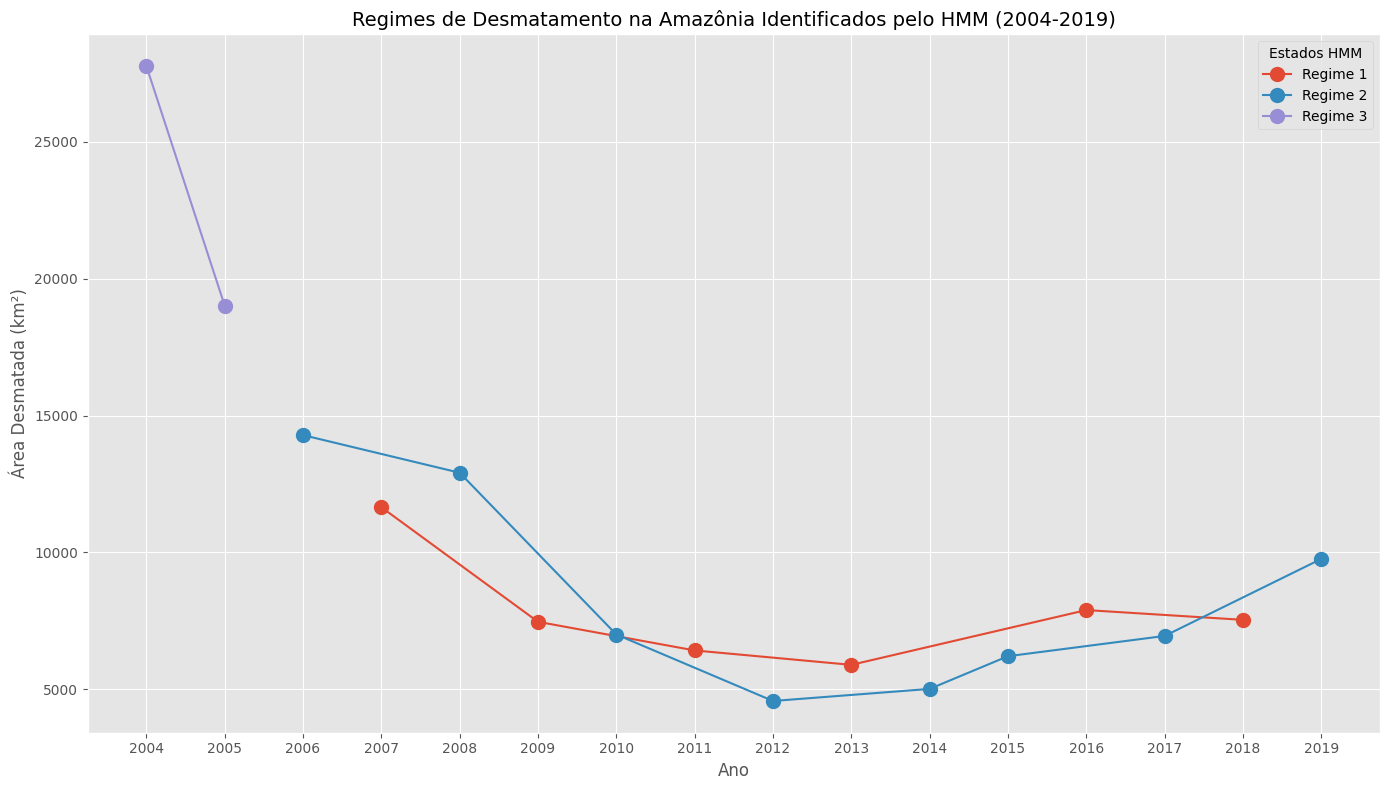


Sequência de estados ocultos detectada:
Ano 2004: Regime 3
Ano 2005: Regime 3
Ano 2006: Regime 2
Ano 2007: Regime 1
Ano 2008: Regime 2
Ano 2009: Regime 1
Ano 2010: Regime 2
Ano 2011: Regime 1
Ano 2012: Regime 2
Ano 2013: Regime 1
Ano 2014: Regime 2
Ano 2015: Regime 2
Ano 2016: Regime 1
Ano 2017: Regime 2
Ano 2018: Regime 1
Ano 2019: Regime 2


In [4]:
X = np.column_stack([
    dados_norm['Desmatamento_Norm'].values, 
    dados_norm['Queimadas_Norm'].values
])

n_estados = 3

modelo_hmm = hmm.GaussianHMM(
    n_components=n_estados,
    covariance_type="full",
    n_iter=1000,
    random_state=42
)

modelo_hmm.fit(X)
estados_ocultos = modelo_hmm.predict(X)
dados_combinados['Estado_HMM'] = estados_ocultos

print("Log de probabilidade do modelo: ", modelo_hmm.score(X))
print("Número de iterações realizadas: ", modelo_hmm.monitor_.iter)
print("\nMatriz de transição (A):")
print(modelo_hmm.transmat_)
print("\nMédias das distribuições de emissão (mu):")
print(modelo_hmm.means_)

print("\nMatrizes de covariância das distribuições de emissão:")
for i, covar in enumerate(modelo_hmm.covars_):
    print(f"Estado {i}:")
    print(covar)
plt.figure(figsize=(14, 8))

for estado in range(n_estados):
    mask = estados_ocultos == estado
    plt.plot(dados_combinados['Ano'][mask], dados_combinados['Desmatamento_Total'][mask], 
             'o-', markersize=10, label=f'Regime {estado+1}')
plt.title('Regimes de Desmatamento na Amazônia Identificados pelo HMM (2004-2019)', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Área Desmatada (km²)', fontsize=12)
plt.legend(title='Estados HMM')
plt.grid(True)
plt.xticks(dados_combinados['Ano'])
plt.tight_layout()
plt.show()

print("\nSequência de estados ocultos detectada:")
for ano, estado in zip(dados_combinados['Ano'], estados_ocultos):
    print(f"Ano {ano}: Regime {estado+1}")

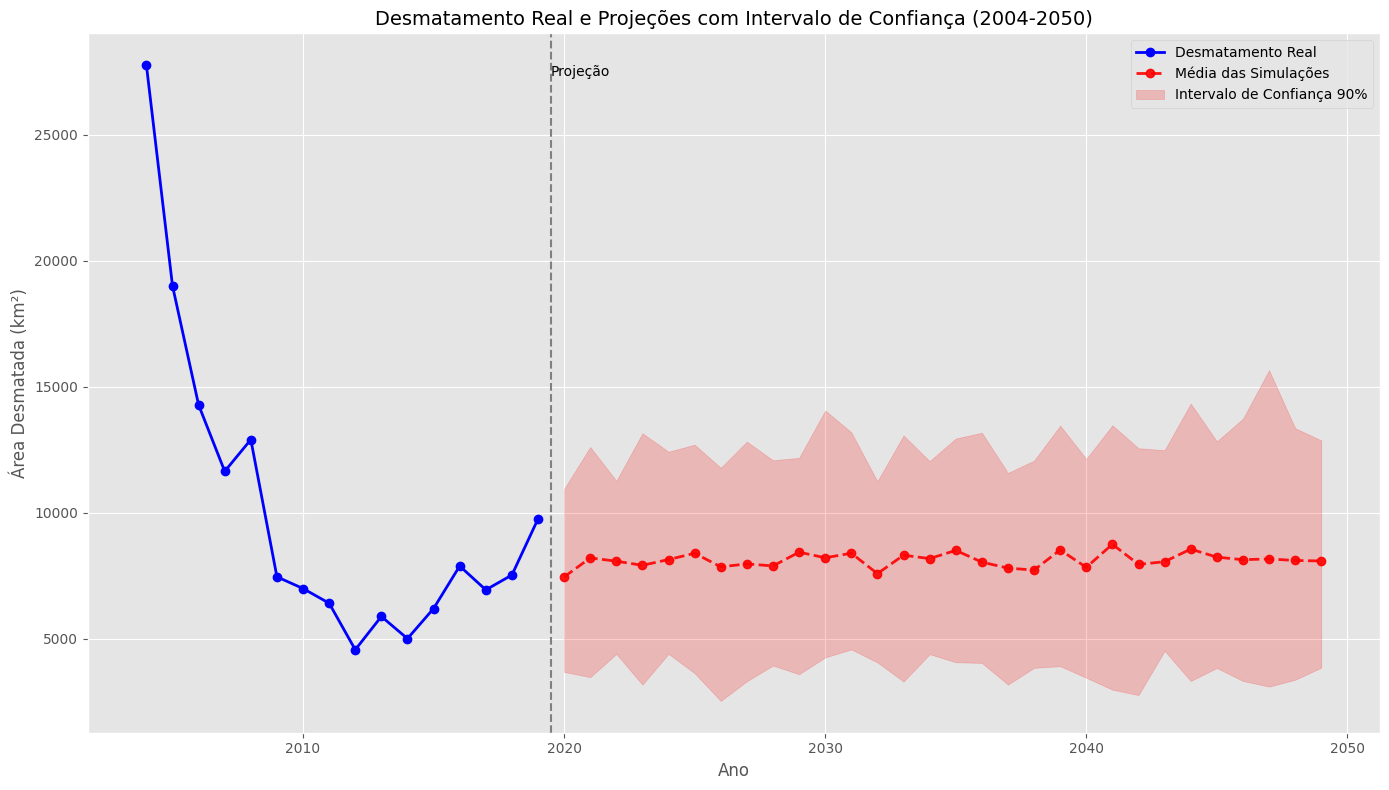

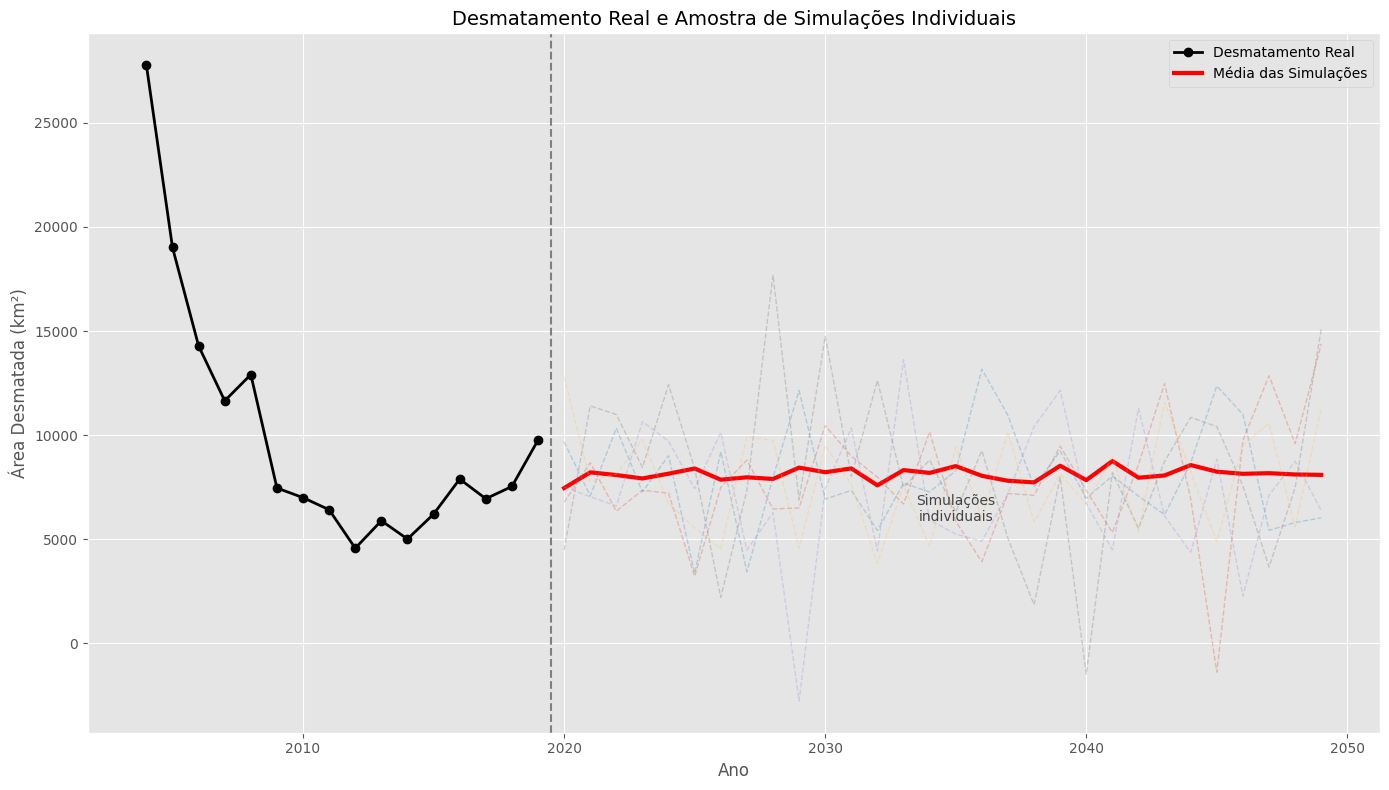

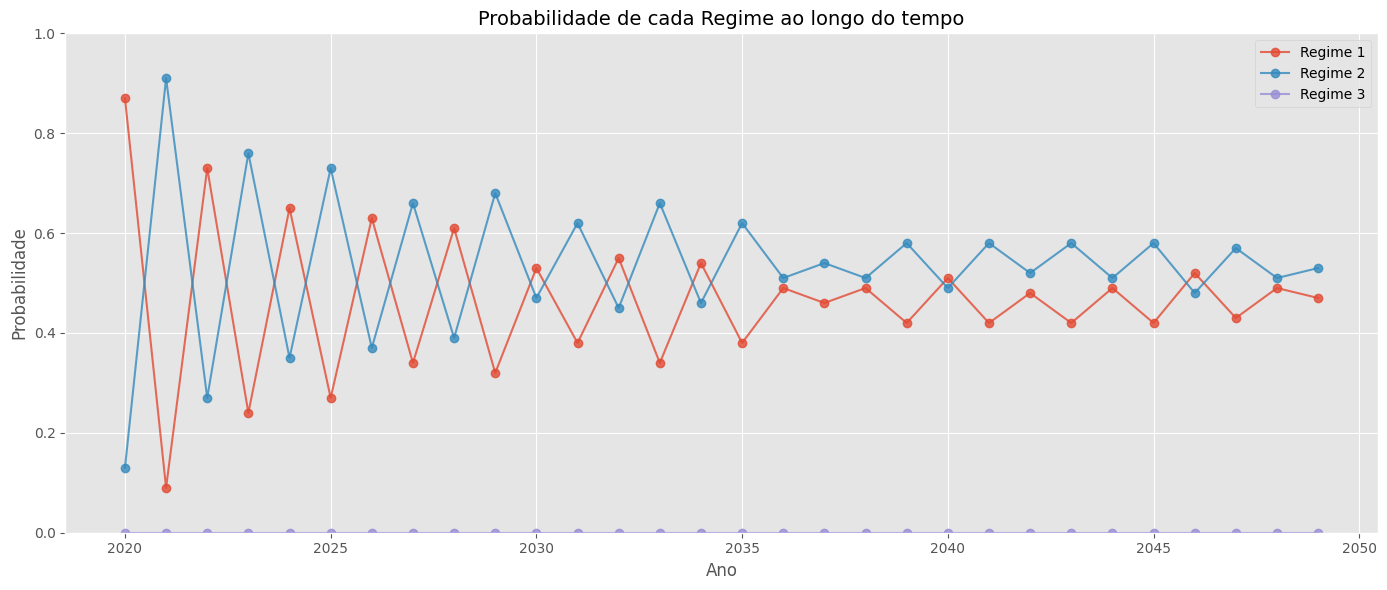

In [5]:
probabilidades_transicao = modelo_hmm.transmat_
estado_atual = estados_ocultos[-1]
prox_estado_mais_provavel = np.argmax(probabilidades_transicao[estado_atual])

num_anos = 30
num_simulacoes = 100
anos_futuros = list(range(2020, 2020 + num_anos))
todas_simulacoes_desmatamento = np.zeros((num_simulacoes, num_anos))
todas_simulacoes_queimadas = np.zeros((num_simulacoes, num_anos))
todos_estados_simulados = np.zeros((num_simulacoes, num_anos), dtype=int)

for sim in range(num_simulacoes):
    estado_atual = estados_ocultos[-1]
    estados_sim = []
    observacoes_sim = []
    
    for _ in range(num_anos):
        estado_atual = np.random.choice(range(n_estados), p=probabilidades_transicao[estado_atual])
        estados_sim.append(estado_atual)
        
        media = modelo_hmm.means_[estado_atual]
        covariancia = modelo_hmm.covars_[estado_atual]
        observacao = np.random.multivariate_normal(mean=media, cov=covariancia)
        observacoes_sim.append(observacao)
    
    observacoes_sim = np.array(observacoes_sim)
    
    desmatamento_sim = observacoes_sim[:, 0] * (dados_combinados['Desmatamento_Total'].max() - 
                                              dados_combinados['Desmatamento_Total'].min()) + dados_combinados['Desmatamento_Total'].min()
    queimadas_sim = observacoes_sim[:, 1] * (dados_combinados['Numero_Queimadas'].max() - 
                                           dados_combinados['Numero_Queimadas'].min()) + dados_combinados['Numero_Queimadas'].min()
    
    todas_simulacoes_desmatamento[sim] = desmatamento_sim
    todas_simulacoes_queimadas[sim] = queimadas_sim
    todos_estados_simulados[sim] = np.array(estados_sim)

media_desmatamento = np.mean(todas_simulacoes_desmatamento, axis=0)
limite_inferior_desmatamento = np.percentile(todas_simulacoes_desmatamento, 5, axis=0)
limite_superior_desmatamento = np.percentile(todas_simulacoes_desmatamento, 95, axis=0)

plt.figure(figsize=(14, 8))
plt.plot(dados_combinados['Ano'], dados_combinados['Desmatamento_Total'], 
         'bo-', linewidth=2, label='Desmatamento Real')
plt.plot(anos_futuros, media_desmatamento, 
         'ro--', alpha=0.9, linewidth=2, label='Média das Simulações')
plt.fill_between(anos_futuros, limite_inferior_desmatamento, limite_superior_desmatamento, 
                color='red', alpha=0.2, label='Intervalo de Confiança 90%')
plt.axvline(x=2019.5, color='gray', linestyle='--')
plt.text(2019.5, dados_combinados['Desmatamento_Total'].max(), 'Projeção', va='top', ha='left')
plt.title('Desmatamento Real e Projeções com Intervalo de Confiança (2004-2050)', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Área Desmatada (km²)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
plt.plot(dados_combinados['Ano'], dados_combinados['Desmatamento_Total'], 
         'ko-', linewidth=2, label='Desmatamento Real')
plt.plot(anos_futuros, media_desmatamento, 
         'r-', linewidth=3, label='Média das Simulações')
for i in range(5):
    plt.plot(anos_futuros, todas_simulacoes_desmatamento[i], 
             linestyle='--', alpha=0.3, linewidth=1)
plt.text(anos_futuros[15], todas_simulacoes_desmatamento[0][15], 'Simulações\nindividuais', 
         ha='center', fontsize=10, alpha=0.7)
plt.axvline(x=2019.5, color='gray', linestyle='--')
plt.title('Desmatamento Real e Amostra de Simulações Individuais', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Área Desmatada (km²)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

freq_regimes = np.zeros((n_estados, num_anos))
for t in range(num_anos):
    for s in range(n_estados):
        freq_regimes[s, t] = np.sum(todos_estados_simulados[:, t] == s) / num_simulacoes

plt.figure(figsize=(14, 6))
for s in range(n_estados):
    plt.plot(anos_futuros, freq_regimes[s], '-o', alpha=0.8, label=f'Regime {s+1}')
plt.title('Probabilidade de cada Regime ao longo do tempo', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Probabilidade', fontsize=12)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
dados_dbn = dados_cat.copy()

dados_dbn_t = []

for i in range(1, len(dados_dbn)):
    row = {
        'ElNino_t-1': dados_dbn['Status'][i-1],
        'Queimadas_t-1': dados_dbn['Queimadas_Cat'][i-1],
        'Desmatamento_t-1': dados_dbn['Desmatamento_Cat'][i-1],
        'ElNino_t': dados_dbn['Status'][i],
        'Queimadas_t': dados_dbn['Queimadas_Cat'][i],
        'Desmatamento_t': dados_dbn['Desmatamento_Cat'][i],
        'Ano_t-1': dados_dbn['Ano'][i-1],
        'Ano_t': dados_dbn['Ano'][i]
    }
    dados_dbn_t.append(row)

df_dbn = pd.DataFrame(dados_dbn_t)
print("Dados estruturados para Rede Bayesiana Dinâmica:")
print(df_dbn)

modelo_bn = DiscreteBayesianNetwork([
    ('ElNino_t-1', 'Queimadas_t-1'),
    ('ElNino_t-1', 'ElNino_t'),
    ('Queimadas_t-1', 'Desmatamento_t-1'),
    ('Desmatamento_t-1', 'Desmatamento_t'),
    ('ElNino_t', 'Queimadas_t'),
    ('Queimadas_t', 'Desmatamento_t')
])

print("\nEstimando os parâmetros da rede bayesiana...")

modelo_bn.fit(df_dbn, estimator=BayesianEstimator)

print("\nTabelas de Probabilidade Condicional (CPDs) estimadas:")
for cpd in modelo_bn.get_cpds():
    print(f"\nCPD para {cpd.variable}:")
    print(cpd)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'ElNino_t-1': 'C', 'Queimadas_t-1': 'C', 'Desmatamento_t-1': 'C', 'ElNino_t': 'C', 'Queimadas_t': 'C', 'Desmatamento_t': 'C', 'Ano_t-1': 'N', 'Ano_t': 'N'}


Dados estruturados para Rede Bayesiana Dinâmica:
   ElNino_t-1 Queimadas_t-1 Desmatamento_t-1 ElNino_t Queimadas_t  \
0     El Nino          Alto             Alto  El Nino        Alto   
1     El Nino          Alto             Alto  El Nino       Baixo   
2     El Nino         Baixo             Alto  El Nino       Medio   
3     El Nino         Medio             Alto  La Nina       Baixo   
4     La Nina         Baixo             Alto  El Nino       Baixo   
5     El Nino         Baixo            Medio  El Nino       Baixo   
6     El Nino         Baixo            Medio  La Nina       Baixo   
7     La Nina         Baixo            Medio  La Nina       Baixo   
8     La Nina         Baixo            Baixo  Neutral       Baixo   
9     Neutral         Baixo            Baixo  El Nino       Baixo   
10    El Nino         Baixo            Baixo  El Nino       Baixo   
11    El Nino         Baixo            Medio  El Nino       Baixo   
12    El Nino         Baixo            Medio  La Nina 

Inferência 1: P(Desmatamento_t | ElNino_t = 'El Niño')
+-----------------------+-----------------------+
| Desmatamento_t        |   phi(Desmatamento_t) |
+=======================+=======================+
| Desmatamento_t(Alto)  |                0.2966 |
+-----------------------+-----------------------+
| Desmatamento_t(Baixo) |                0.2366 |
+-----------------------+-----------------------+
| Desmatamento_t(Medio) |                0.4668 |
+-----------------------+-----------------------+

Inferência 2: P(Desmatamento_t | Desmatamento_t-1 = 'Alto', ElNino_t = 'El Niño')
+-----------------------+-----------------------+
| Desmatamento_t        |   phi(Desmatamento_t) |
+=======================+=======================+
| Desmatamento_t(Alto)  |                0.6539 |
+-----------------------+-----------------------+
| Desmatamento_t(Baixo) |                0.0699 |
+-----------------------+-----------------------+
| Desmatamento_t(Medio) |                0.2762 |
+-----------

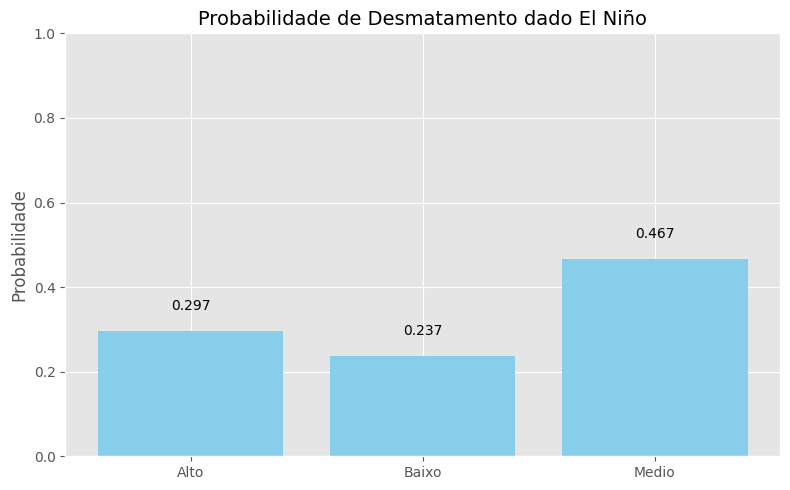

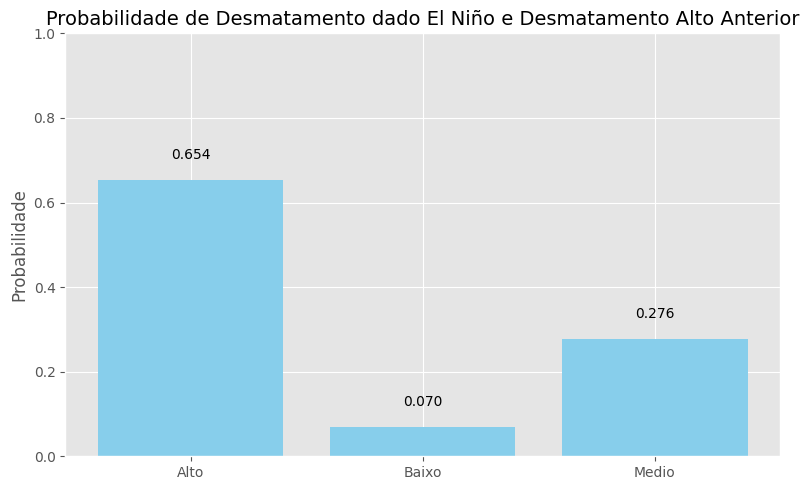

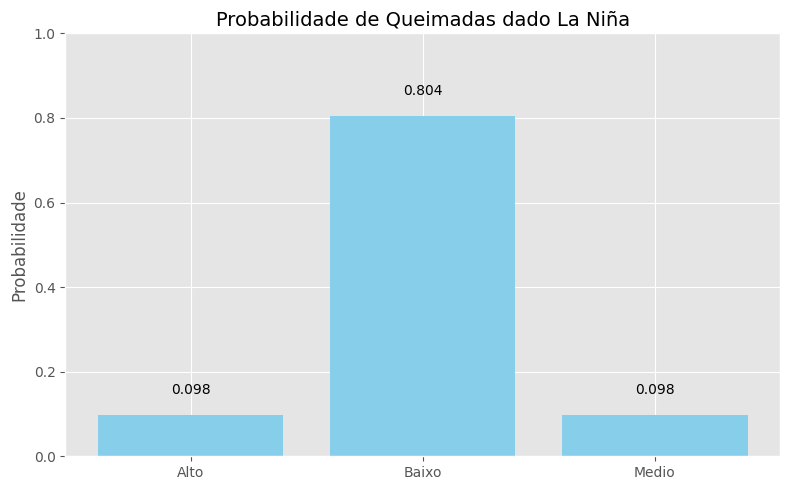

In [7]:
inferencia = VariableElimination(modelo_bn)

print("Inferência 1: P(Desmatamento_t | ElNino_t = 'El Niño')")
prob_desm_dada_elnino = inferencia.query(variables=['Desmatamento_t'], 
                                        evidence={'ElNino_t': 'El Nino'})

print(prob_desm_dada_elnino)

print("\nInferência 2: P(Desmatamento_t | Desmatamento_t-1 = 'Alto', ElNino_t = 'El Niño')")
prob_desm_dado_desm_elnino = inferencia.query(
    variables=['Desmatamento_t'], 
    evidence={'Desmatamento_t-1': 'Alto', 'ElNino_t': 'El Nino'}
)
print(prob_desm_dado_desm_elnino)

print("\nInferência 3: P(Queimadas_t | ElNino_t = 'La Niña')")
prob_queimadas_dada_lanina = inferencia.query(
    variables=['Queimadas_t'], 
    evidence={'ElNino_t': 'La Nina'}
)
print(prob_queimadas_dada_lanina)

def plot_distribution(distribution, title):
    states = distribution.state_names[distribution.variables[0]]
    values = distribution.values
    
    plt.figure(figsize=(8, 5))
    plt.bar(states, values, color='skyblue')
    plt.title(title, fontsize=14)
    plt.ylabel('Probabilidade', fontsize=12)
    plt.ylim(0, 1.0)
    
    for i, v in enumerate(values):
        plt.text(i, v + 0.05, f'{v:.3f}', ha='center')
    
    plt.tight_layout()
    plt.show()

plot_distribution(prob_desm_dada_elnino, 'Probabilidade de Desmatamento dado El Niño')
plot_distribution(prob_desm_dado_desm_elnino, 'Probabilidade de Desmatamento dado El Niño e Desmatamento Alto Anterior')
plot_distribution(prob_queimadas_dada_lanina, 'Probabilidade de Queimadas dado La Niña')

===== Aplicações Práticas da Rede Bayesiana =====


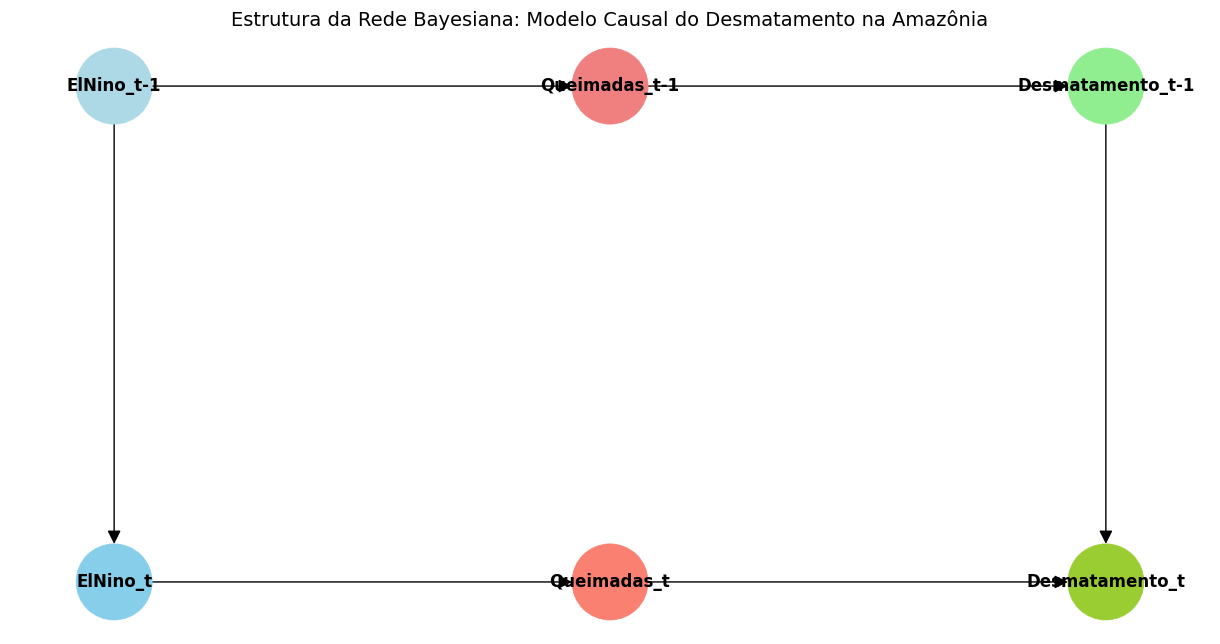


----- Cenários Críticos para Tomada de Decisão -----

Cenário: Alto Risco: El Niño durante período de desmatamento já elevado
Condições: {'ElNino_t': 'El Nino', 'Desmatamento_t-1': 'Alto'}
Resultado mais provável: Desmatamento Alto (Probabilidade: 0.65)


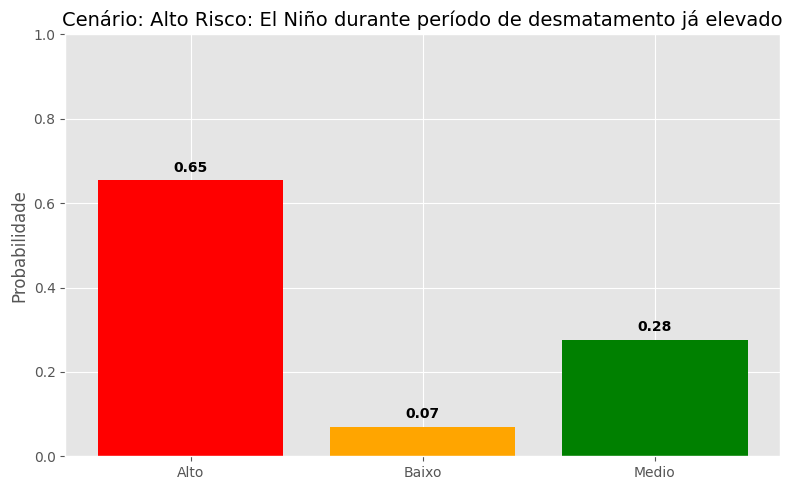


Cenário: Baixo Risco: La Niña com desmatamento controlado
Condições: {'ElNino_t': 'La Nina', 'Desmatamento_t-1': 'Baixo'}
Resultado mais provável: Desmatamento Baixo (Probabilidade: 0.56)


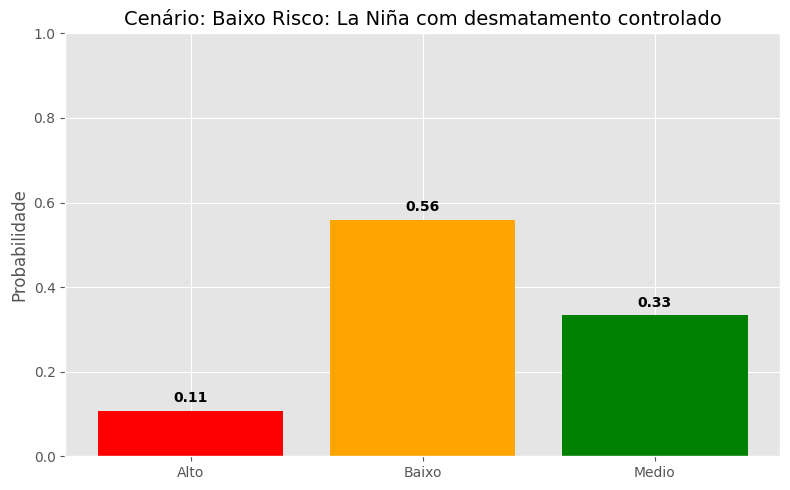


Cenário: Mitigação: El Niño mas com controle efetivo de queimadas
Condições: {'ElNino_t': 'El Nino', 'Queimadas_t': 'Baixo'}
Resultado mais provável: Desmatamento Medio (Probabilidade: 0.54)


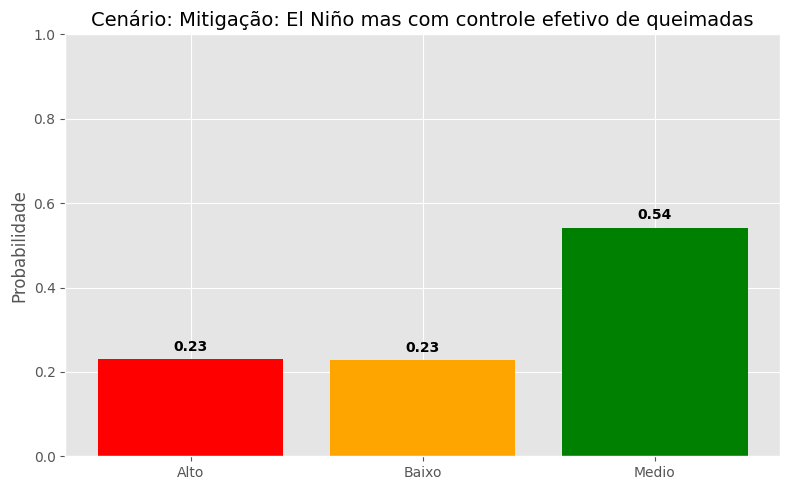


----- Comparação de Previsões entre os modelos -----
Condições atuais (2019): El Niño/La Niña = El Nino, Desmatamento = Medio
Previsão HMM para 2020: Desmatamento Baixo
Previsão Rede Bayesiana para 2020: Desmatamento Medio (Probabilidade: 0.70)


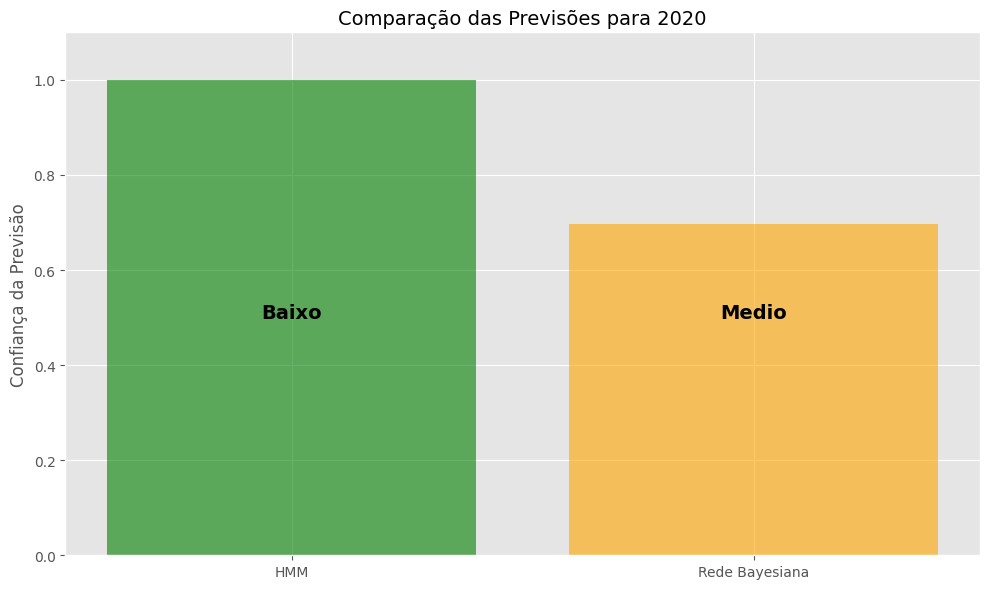

In [8]:
# ---------- Análise Avançada com a Rede Bayesiana ----------

print("===== Aplicações Práticas da Rede Bayesiana =====")

# 1. Visualização da estrutura da rede para entender o modelo causal
plt.figure(figsize=(12, 6))
G = nx.DiGraph()
for edge in modelo_bn.edges():
    G.add_edge(edge[0], edge[1])

pos = {
    'ElNino_t-1': (0, 2),
    'Queimadas_t-1': (1, 2),
    'Desmatamento_t-1': (2, 2),
    'ElNino_t': (0, 1),
    'Queimadas_t': (1, 1),
    'Desmatamento_t': (2, 1)
}

node_colors = {
    'ElNino_t-1': 'lightblue',
    'Queimadas_t-1': 'lightcoral',
    'Desmatamento_t-1': 'lightgreen',
    'ElNino_t': 'skyblue',
    'Queimadas_t': 'salmon',
    'Desmatamento_t': 'yellowgreen'
}

node_colors_list = [node_colors[node] for node in G.nodes()]
nx.draw(G, pos=pos, with_labels=True, node_size=3000, node_color=node_colors_list,
        font_weight='bold', arrowsize=20, font_size=12)

plt.title('Estrutura da Rede Bayesiana: Modelo Causal do Desmatamento na Amazônia', fontsize=14)
plt.tight_layout()
plt.show()

# 2. Análise de cenários críticos para políticas públicas
print("\n----- Cenários Críticos para Tomada de Decisão -----")

def analisar_cenario(nome, evidencias):
    print(f"\nCenário: {nome}")
    print(f"Condições: {evidencias}")
    
    resultado = inferencia.query(['Desmatamento_t'], evidence=evidencias)
    probabilidades = {estado: prob for estado, prob in zip(resultado.state_names['Desmatamento_t'], resultado.values)}
    
    estado_mais_provavel = max(probabilidades, key=probabilidades.get)
    prob_max = probabilidades[estado_mais_provavel]
    
    print(f"Resultado mais provável: Desmatamento {estado_mais_provavel} (Probabilidade: {prob_max:.2f})")
    
    plt.figure(figsize=(8, 5))
    cores = ['green', 'orange', 'red'] if resultado.state_names['Desmatamento_t'][0] == 'Baixo' else ['red', 'orange', 'green']
    plt.bar(resultado.state_names['Desmatamento_t'], resultado.values, color=cores)
    plt.title(f'Cenário: {nome}', fontsize=14)
    plt.ylabel('Probabilidade', fontsize=12)
    plt.ylim(0, 1)
    
    for i, v in enumerate(resultado.values):
        plt.text(i, v + 0.02, f'{v:.2f}', ha='center', fontweight='bold')
        
    plt.tight_layout()
    plt.show()
    
    return estado_mais_provavel, prob_max

# Cenário 1: Fenômeno El Niño com desmatamento já alto
alto_risco = {'ElNino_t': 'El Nino', 'Desmatamento_t-1': 'Alto'}
analisar_cenario("Alto Risco: El Niño durante período de desmatamento já elevado", alto_risco)

# Cenário 2: La Niña com controle prévio do desmatamento
baixo_risco = {'ElNino_t': 'La Nina', 'Desmatamento_t-1': 'Baixo'}
analisar_cenario("Baixo Risco: La Niña com desmatamento controlado", baixo_risco)

# Cenário 3: El Niño mas com controle de queimadas
mitigacao = {'ElNino_t': 'El Nino', 'Queimadas_t': 'Baixo'}
analisar_cenario("Mitigação: El Niño mas com controle efetivo de queimadas", mitigacao)

# 3. Comparação com as previsões do HMM para o próximo ano
print("\n----- Comparação de Previsões entre os modelos -----")

# Previsão com HMM 
estado_hmm_atual = estados_ocultos[-1]
prox_estado_hmm = np.argmax(modelo_hmm.transmat_[estado_hmm_atual])

# Identificar qual regime corresponde a qual nível de desmatamento
regimes_medios = {}
for estado in range(n_estados):
    mask = estados_ocultos == estado
    media_desmatamento = dados_combinados.loc[mask, 'Desmatamento_Total'].mean()
    regimes_medios[estado] = media_desmatamento

categorias = ['Baixo', 'Medio', 'Alto']
valores_ordenados = sorted(regimes_medios.items(), key=lambda x: x[1])
mapeamento_regime_categoria = {regime[0]: categorias[i] for i, regime in enumerate(valores_ordenados)}

previsao_hmm = mapeamento_regime_categoria[prox_estado_hmm]

# Previsão com a Rede Bayesiana usando último estado conhecido
ultimo_elnino = dados_cat.iloc[-1]['Status']
ultimo_desmatamento = dados_cat.iloc[-1]['Desmatamento_Cat']

evidencias_bn = {
    'ElNino_t-1': ultimo_elnino,
    'Desmatamento_t-1': ultimo_desmatamento
}

resultado_bn = inferencia.query(['Desmatamento_t'], evidence=evidencias_bn)
previsao_bn = resultado_bn.state_names['Desmatamento_t'][np.argmax(resultado_bn.values)]
prob_bn = np.max(resultado_bn.values)

print(f"Condições atuais (2019): El Niño/La Niña = {ultimo_elnino}, Desmatamento = {ultimo_desmatamento}")
print(f"Previsão HMM para 2020: Desmatamento {previsao_hmm}")
print(f"Previsão Rede Bayesiana para 2020: Desmatamento {previsao_bn} (Probabilidade: {prob_bn:.2f})")

# Visualização comparativa
plt.figure(figsize=(10, 6))
modelos = ['HMM', 'Rede Bayesiana']
previsoes = [previsao_hmm, previsao_bn]

# Definir cores baseadas na severidade das previsões
cores = []
for prev in previsoes:
    if prev == 'Alto':
        cores.append('red')
    elif prev == 'Medio':
        cores.append('orange')
    else:
        cores.append('green')

plt.bar(modelos, [1, prob_bn], color=cores, alpha=0.6)
plt.title('Comparação das Previsões para 2020', fontsize=14)
plt.ylabel('Confiança da Previsão', fontsize=12)
plt.ylim(0, 1.1)

# Adicionar as previsões como texto
for i, (modelo, prev) in enumerate(zip(modelos, previsoes)):
    plt.text(i, 0.5, f"{prev}", ha='center', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()